# CatBoost

CatBoostはYandexが中心となって開発しているGBDTのOSSライブラリ

標準的なGBDTに比べ、様々な工夫がされている

:::{admonition} CatBoostの特徴

- カテゴリカル特徴量のサポート（Target Encodingを改良したような手法をとる）
- 勾配の不偏推定（木の構築と葉の値の設定に使うデータセットを分ける）
- oblivious trees（同じ分割の深さのノードはすべて同じ分割条件を使う決定木）を使う

:::

## 関連論文

[Reference papers | CatBoost](https://catboost.ai/docs/en/concepts/educational-materials-papers)

- [CatBoost: unbiased boosting with categorical features](https://arxiv.org/abs/1706.09516)
    - CatBoost の Ordered Boosting と Ordered Categorical Features Statistics の説明
- [CatBoost: gradient boosting with categorical features support](http://learningsys.org/nips17/assets/papers/paper_11.pdf)
    - CatBoostの基本的な動作原理の説明
- [Minimal Variance Sampling in Stochastic Gradient Boosting](https://arxiv.org/abs/1910.13204)
    - CatBoostのデフォルトのサンプリング手法MVSについて
- [Finding Influential Training Samples for Gradient Boosted Decision Trees](https://arxiv.org/abs/1802.06640)
    - あるサンプルに対する予測について影響の大きい訓練データ中の事例を探索するアルゴリズムについて
- [Which Tricks are Important for Learning to Rank?](https://arxiv.org/abs/2204.01500)
    - ランキング学習の誤差関数について、LambdaMART, YetiRank, StochasticRankを比較してYetiRankの改良を提案
- [Gradient Boosting Performs Gaussian Process Inference](https://arxiv.org/abs/2206.05608)
    - 対称決定木（symmetric decision tress）の勾配ブースティングはカーネル法と等価であり、カーネルリッジ回帰問題の解へと変換できることを示した
    - つまり、CatBoostでガウス過程と同様の結果が得られることを示した。
    - 実装：[sample_gaussian_process | CatBoost](https://catboost.ai/docs/en/concepts/python-reference_sample_gaussian_process)

[Prokhorenkova, et al. (2018). CatBoost: unbiased boosting with categorical features. NeurIPS2018](https://arxiv.org/pdf/1706.09516.pdf)

## Categorical featuresの扱い

（参考：[Dorogush, et al. (2018). CatBoost: gradient boosting with categorical features support. NIPS2017](http://learningsys.org/nips17/assets/papers/paper_11.pdf)）

### 既存手法

#### One-hot Encoding

もとの特徴量を、カテゴリの数だけの新しい二値特徴量に置き換える方法。カーディナリティが低いカテゴリカル特徴量に対して使われる。

#### Target Encoding

別の方法として、ラベル値を用いてカテゴリごとの統計量を計算する手法がある。  
データセット $\{ (x_i, Y_i) \}$ が与えられており、$x_i$ は数値的およびカテゴリ的特徴を含むベクトル、$Y_i$ はラベルであるとする。  
最も単純な方法は、カテゴリ全体の平均ラベル値で置き換えるものである。すなわち、カテゴリ $x_{i,k}$ は次のように置き換えられる：

$$
\frac{\sum_{j=1}^n [x_{j,k} = x_{i,k}] \cdot Y_j}
     {\sum_{j=1}^n [x_{j,k} = x_{i,k}]}
$$

ここで、$[\cdot]$ はイベルソン括弧（条件が真なら1、偽なら0）である。  
しかし、この方法は明らかに **過学習** を引き起こす。  
例えば、あるカテゴリがデータ中に1回しか出現しない場合、その数値はそのラベルと等しくなってしまう。

この問題を避けるための単純な方法は、データセットを2つに分割し、一方で統計量を計算し、もう一方で訓練することである。  
しかしこれはデータ量を減らしてしまう。

### CatBoost における戦略

CatBoost は過学習を抑制しつつ、全データを利用できる効率的な戦略を採る。

データセットのランダムな順列を実行し、各事例について、順列内の指定されたカテゴリ値の前に同じカテゴリ値が配置されている事例の平均ラベル値を計算する。


つまり、$x_{\sigma_p, k}$ は

$$
\frac{\sum_{j=1}^{p-1} [x_{\sigma_j, k} = x_{\sigma_p, k}] \cdot Y_{\sigma_j} + a \cdot P}
     {\sum_{j=1}^{p-1} [x_{\sigma_j, k} = x_{\sigma_p, k}] + a}
\tag{1}
$$

に置き換える。

ここで

- $\sigma = (\sigma_1, \dots, \sigma_n)$は順列
- $a > 0$ は **prior の重み**
- $P$ は **prior 値**（例えば回帰なら平均ラベル値、二値分類なら正例の事前確率）

である。

prior を導入することにより、出現頻度の低いカテゴリから生じるノイズを軽減できる。  
さらに複数の順列を用いることも可能であるが、単純に統計量を併用すると過学習を起こす。  
CatBoost では次節で述べる新しい葉値計算法により、複数順列の利用を安全に行える。

### 特徴の組み合わせ

複数のカテゴリ特徴を組み合わせて新しい特徴を作ることもできる。  
例えば、音楽推薦タスクにおいて「ユーザーID」と「音楽ジャンル」があるとする。  
ユーザーが特定のジャンルを好む情報（例：「ユーザー123はロックが好き」）は、各特徴を別々に変換すると失われるが、2つを組み合わせることで新たな強力な特徴となる。

しかし、全ての組み合わせを考慮すると組み合わせ数が指数的に増えるため、CatBoost では **貪欲法 (greedy approach)** により木構築中の分割で生成可能な組み合わせのみを考慮する。

- 最初の分割では組み合わせを考慮しない。  
- 以降の分割では、現在の木で使われたカテゴリ特徴とデータセット中の他のカテゴリ特徴を組み合わせる。  
- 組み合わせ値は「その場で」数値に変換される。  
- 数値特徴とカテゴリ特徴の組み合わせも同様に扱われる。


### 実装上の重要な詳細

カテゴリを数値に置き換えるもう一つの単純で強力な方法は、**そのカテゴリの出現回数**を計算することである。  
CatBoost ではこの統計も計算し、特徴の組み合わせにも適用している。

また、CatBoost アルゴリズムの各ステップで最適な prior を適合させるために、複数の prior を試し、それぞれについて特徴を構築する。  
これは前述の標準的手法よりも品質面で優れている。


## 勾配推定のバイアスの削減

CatBoost を含む標準的な勾配ブースティング実装は、現在のモデルの勾配を近似する新しい木を逐次構築する。  
しかし、古典的なブースティングアルゴリズムは、**バイアスのある点ごとの勾配推定 (biased pointwise gradient estimates)** に起因する過学習の問題を抱えている。  
各ステップで使用される勾配は、そのモデル自体の学習に使われたデータ点を用いて推定されるため、  
ある特徴空間領域における推定勾配の分布が、その領域における真の勾配分布とずれてしまう。  
これが過学習を引き起こす。

この「勾配バイアス」の問題は、既存研究（例えば Breiman 1996, Friedman 2002）で議論されている。  
我々はこの問題の形式的解析を別論文 (Dorogush, et al. 2017) で行い、古典的勾配ブースティングの修正版を提案した。  
CatBoost はその修正版の1つを実装している。


:::{margin} 参考文献

- Breiman (1996). Out-of-bag estimation.
- Friedman (2002). Stochastic gradient boosting. Computational statistics & data analysis, 38(4), 367-378.
- Dorogush, et al. (2017). [Fighting biases with dynamic boosting](https://arxiv.org/abs/1706.09516v1). arXiv preprint arXiv:1706.09516.
    - ※のちの[CatBoost: unbiased boosting with categorical features. NeurIPS2018](https://arxiv.org/pdf/1706.09516.pdf)

:::

多くの GBDT 実装（XGBoost, LightGBM など）では、新しい木を構築する際に以下の2段階を踏む：

1. **木構造の選択**  
2. **葉の値の設定（木構造が固定された後）**

CatBoost では、第2段階（葉値計算）は従来の GBDT 方式で行うが、第1段階（木構造選択）において修正版を採用している。

理論解析および実験的結果に基づく直感によれば、 **勾配の不偏推定量** を用いることが極めて重要である。  

### 勾配の不偏推定量

$i$ 本の木を構築した後のモデルを $F^i$ とし、$i$ 本の木構築後の第 $k$ 番目の訓練サンプル上の勾配値を $g^i(X_k, Y_k)$ とする。

勾配 $g^i(X_k, Y_k)$ をモデル $F^i$ に対して非バイアスにするためには、観測 $X_k$ を含まないように訓練された $F^i$ を得る必要がある。

しかし、すべての訓練サンプルについて非バイアスな勾配を得る必要があるため、どの観測も $F^i$ の学習には使用できない。
これは一見すると、学習過程そのものを不可能にするように見える。

この問題に対処するため、我々は次のトリックを考案する。

:::{admonition} 勾配の不偏推定量 - ordered boosting

- データセットを分割し、各事例 $X_k$ の勾配の推定値を使わずに独立のモデル $M_k$ を訓練する。
- $M_k$ を用いることで、$X_k$ 上の勾配を推定し、その推定値を用いて結果となる木のスコアリングを行う。

:::

以下に、このトリックの手順を実現する擬似コードを示す。
損失関数を $Loss(y, a)$ とし、ここで $y$ はラベル値、$a$ はモデルの出力値とする。


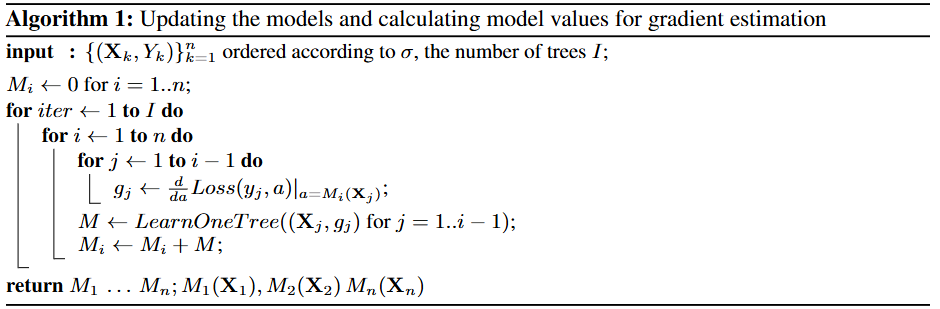

ここで$M_i$は$X_i$を使わずに訓練されている点に注意。

なお、CatBoostの実装では、すべての $M_i$ が同じ木の構造を共有することを用いてこのアルゴリズムを緩和させている（→ ordered boosting）

CatBoost では、学習データセットの $s$ 個のランダムな順列（permutation）を生成する。
複数の順列を使用することで、アルゴリズムのロバスト性を高める。
すなわち、ランダムな順列をサンプリングし、その順列に基づいて勾配を計算する。
これらの順列は、カテゴリ特徴の統計量を計算する際にも使用されるものと同じである。

異なるモデルの学習には異なる順列を使用するため、
複数の順列を用いても過学習は生じない。

各順列 $\sigma$ に対して、我々は $n$ 個の異なるモデル $M_i$ を訓練する（前節で示した通りである）。
これは、1本の木を構築する際に、各順列に対して $O(n^2)$ 個の近似値を保存および再計算する必要があることを意味する。
すなわち、各モデル $M_i$ について、$M_i(X_1), \ldots, M_i(X_i)$ を更新する必要がある。
したがって、この操作の計算量は $O(s n^2)$ となる。

しかし、CatBoostの実装では、この計算量を $O(s n)$ に削減するための重要な工夫を導入している。

各順列について、$O(n^2)$ の値 $M_i(X_j)$ を保存・更新する代わりに、以下のように近似値 $M_i'(X_j)$ を管理する：

$$
i = 1, \ldots, \lfloor \log_2(n) \rfloor
,\quad
j < 2^{i+1}
$$

ここで、$M_i'(X_j)$ は最初の $2^i$ 個のサンプルに基づくサンプル $j$ の近似値である。

したがって、予測値の総数 $M_i'(X_j)$ は

$$
\sum_{0 \leq i \leq \log _2(n)} 2^{i+1}<4 n
$$

を超えない。

木構造を選択する際に使用されるサンプル $X_k$ 上の勾配は、
次の近似 $M_i'(X_k)$（ここで $i = \lfloor \log_2(k) \rfloor$）に基づいて推定される。

## Ordered Boosting

勾配推定のバイアスを除去するための leave-one-out 推定を効率よく行うためのトリック。oblibious trees（対称木）だからこそ使える。


### Prediction Shift

[CatBoost論文のprediction shiftについて完全に理解する - threecourse’s blog](https://threecourse.hatenablog.com/entry/2020/05/29/204944)

- 各iterationで同じ訓練データを使うことの問題
- 1本目と2本目の木の作成で同じデータセットを使うことにより、予測値の期待値に$1 / (n − 1)$ に比例する偏りが発生する。
- prediction shiftの影響を受けないよう、CatBoostではデータ数が少ない場合にはordered boostingというアルゴリズムを使用するようになっている。

## Fast scorer

CatBoost は oblivious trees（オブリビアス木） を基底予測器として用いる （[Kohavi & Li, 1995](https://www.ijcai.org/Proceedings/95-2/Papers/008.pdf)）。

このタイプの木では、同一の分割基準が木のすべてのレベルで使用される。
このような木は構造的にバランスが取れており、過学習を起こしにくい。
勾配ブースティングされたオブリビアス木は、さまざまな学習タスクにおいて成功裏に用いられている（[Ferov & Modrý, 2016](https://arxiv.org/abs/1609.05610), [Gulin, et al., 2011](https://proceedings.mlr.press/v14/gulin11a)）。


オブリビアス木では、各葉のインデックスを、その木の深さに等しい長さの バイナリベクトル として符号化できる。
この事実は CatBoost のモデル評価器において広く利用されており、
まずすべての浮動小数点特徴量、統計量、そして one-hot エンコーディングされた特徴を バイナリ化（binarize） し、
その後、これらのバイナリ特徴を用いてモデルの予測値を計算する。


すべてのサンプルに対するバイナリ特徴値は、連続ベクトル $B$ に格納される。
木の深さを $d$ とすると、葉の値はサイズ $2^d$ の浮動小数点ベクトル内に保存される。
木 $t$ に対して葉のインデックスを計算するには、サンプル $x$ について次のようなバイナリベクトルを構築する：

$$
\sum_{i=0}^{d-1} 2^i \cdot B(x, f(t, i))
$$

ここで、$B(x, f)$ はサンプル $x$ の特徴 $f$ に対するバイナリ値であり、$f(t, i)$ は木 $t$ の深さ $i$ における分割で使用される特徴のインデックスを表す。

このようなベクトルは データ並列的（data-parallel）な方法 で構築でき、最大で 3 倍の高速化を実現する。
その結果、CatBoost のスコアラーは他の既存の実装と比較してはるかに高速であることが実験によって示されている。